In [ ]:
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from skimage.filters import frangi
from skimage.color import rgb2gray
from skimage.morphology import closing, square
from skimage.morphology import remove_small_objects
from skimage.morphology import skeletonize
from skimage.measure import moments_central, moments_hu
import skimage.exposure as exp
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, accuracy_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.neighbors import KNeighborsClassifier
import os
import numpy as np
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall, AUC
from tensorflow.keras.metrics import BinaryIoU
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from ipywidgets import interact, Dropdown
import os


2025-06-11 01:13:15.362360: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-11 01:13:15.463201: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749597195.499057   43878 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749597195.509275   43878 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749597195.594207   43878 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

/tmp/ipykernel_10965/2373217522.py:16: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  binary_closed = closing(binary, square(3))


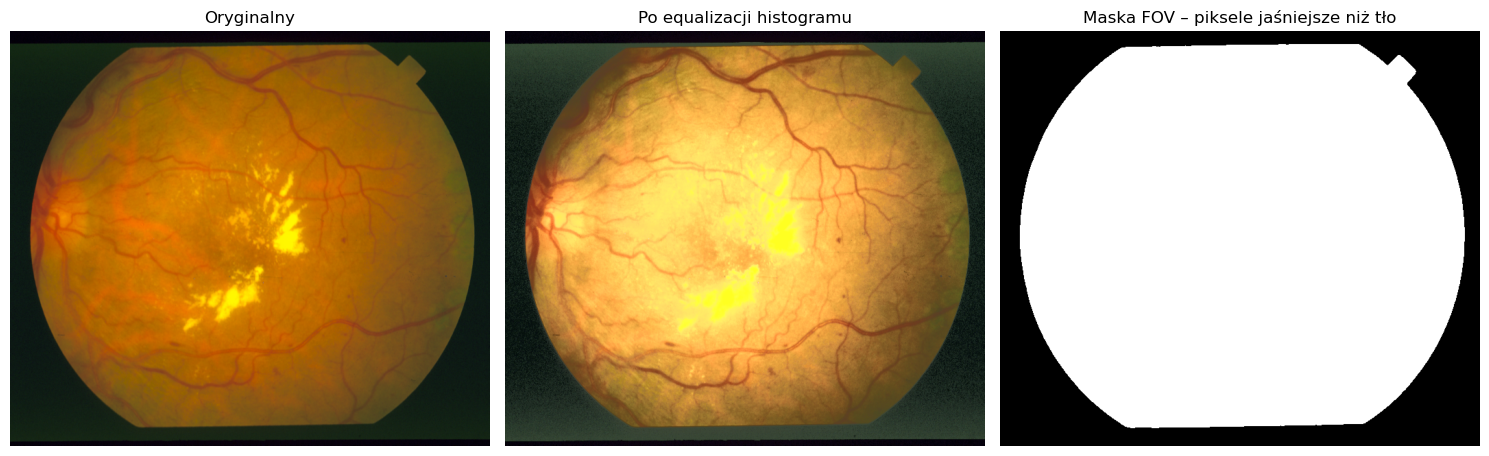

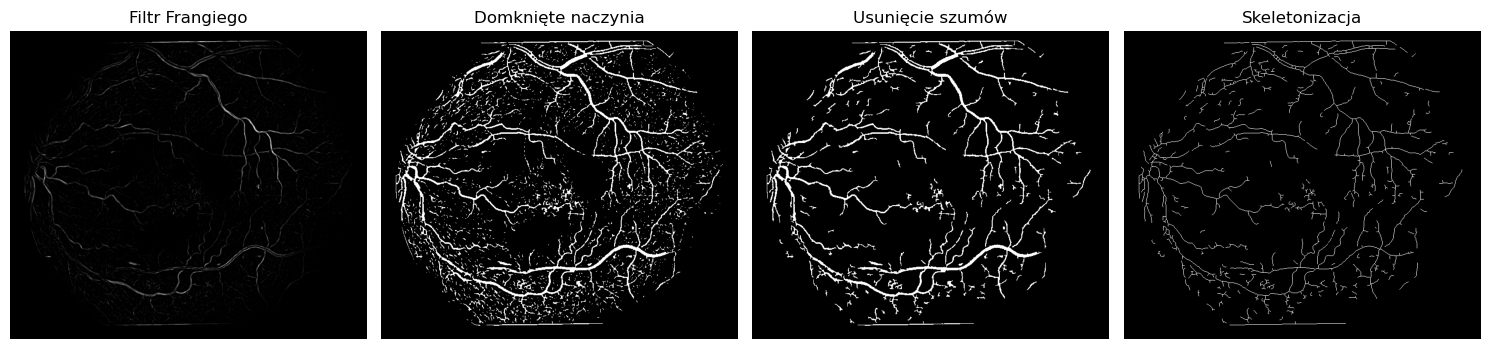

Accuracy: 0.8846
Sensitivity: 0.1104
Specificity: 0.9399
Balanced Accuracy: 0.5251


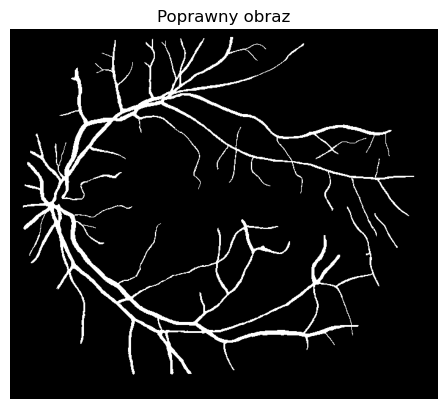

In [ ]:

# Ścieżka do folderu z obrazami
image_dir = 'images'

# Lista dostępnych obrazów .ppm (bez masek .ah)
image_files = [f for f in os.listdir(image_dir) if f.endswith('.ppm') and '.ah' not in f]
image_files.sort()

@interact(filename=Dropdown(options=image_files, description='Obraz:'))
def run_pipeline(filename):
    image_path = os.path.join(image_dir, filename)
    ah_path = image_path.replace('.ppm', '.ah.ppm')

    # 1. Wczytaj kolorowy obraz (BGR)
    img = cv2.imread(image_path)
    ideal_result = cv2.imread(ah_path, 0) > 0

    img_blur = cv2.GaussianBlur(img, (5, 5), 0)
    gray_mask = cv2.cvtColor(img_blur, cv2.COLOR_BGR2GRAY)
    _, fov_mask = cv2.threshold(gray_mask, 45, 255, cv2.THRESH_BINARY)
    fov_mask = fov_mask > 0

    img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
    img_eq = cv2.cvtColor(img_yuv, cv2.COLOR_YCrCb2BGR)
    img_rgb = cv2.cvtColor(img_eq, cv2.COLOR_BGR2RGB)
    gray = rgb2gray(img_rgb)

    # 7. Filtr Frangiego
    frangi_result = frangi(gray)
    frangi_result[~fov_mask] = 0
    thr = np.percentile(frangi_result[fov_mask], 93)
    binary = (frangi_result > thr) & fov_mask

    # 9–11: obróbka morfologiczna
    binary_closed = closing(binary, square(3))
    binary_cleaned = remove_small_objects(binary_closed, min_size=25)
    binary_skeleton = skeletonize(binary_cleaned)

    # Wyświetlanie wyników
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Oryginalny")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Po equalizacji histogramu")
    plt.imshow(img_rgb)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Maska FOV")
    plt.imshow(fov_mask, cmap='gray')
    plt.axis('off')
    plt.show()

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Frangi")
    plt.imshow(frangi_result, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Domknięte")
    plt.imshow(binary_closed, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Po usunięciu szumów")
    plt.imshow(binary_cleaned, cmap='gray')
    plt.axis('off')
    plt.show()

    # Obraz referencyjny
    plt.figure()
    plt.title("Obraz referencyjny (idealny)")
    plt.imshow(ideal_result, cmap='gray')
    plt.axis('off')
    plt.show()

    # Oblicz metryki
    TP = np.logical_and(binary_cleaned == 1, ideal_result == 1).sum()
    TN = np.logical_and(binary_cleaned == 0, ideal_result == 0).sum()
    FP = np.logical_and(binary_cleaned == 1, ideal_result == 0).sum()
    FN = np.logical_and(binary_cleaned == 0, ideal_result == 1).sum()

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    balanced_accuracy = (sensitivity + specificity) / 2

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Sensitivity (Recall): {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"Balanced Accuracy: {balanced_accuracy:.4f}")




In [65]:
images = []
masks = []
for i in range(1, 21):
    images.append(cv2.imread(f"images/im000{i}.ppm"))
    masks.append(cv2.imread(f"images/im000{i}.ah.ppm", cv2.IMREAD_GRAYSCALE))  # Wczytanie masek w skali szarości

# Parametry patchy
window_size = 10
step = 5

features = []
labels = []
rows = []
positions = []

for idx in range(len(images)):
    image = images[idx]
    mask_expert = masks[idx]

    # Rozmycie i CLAHE
    img_blur = cv2.GaussianBlur(image, (5, 5), 0)
    b, g, r = cv2.split(img_blur)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

    b_clahe = clahe.apply(b)
    g_clahe = clahe.apply(g)
    r_clahe = clahe.apply(r)
    img_eq = cv2.merge((b_clahe, g_clahe, r_clahe))

    img_rgb = cv2.cvtColor(img_eq, cv2.COLOR_BGR2RGB)
    gray = rgb2gray(img_rgb)
    
    h, w = gray.shape

    for y in range(0, h - window_size + 1, step):
        for x in range(0, w - window_size + 1, step):

            positions.append((y, x))
            patch = gray[y:y+window_size, x:x+window_size]
            
            var = np.var(patch)

            m_central = moments_central(patch)
            hu = moments_hu(m_central)  # 7 cech
            
            center_y = y + window_size // 2
            center_x = x + window_size // 2
            label = mask_expert[center_y, center_x]
            
            row = {
            "var": var,
            "hu_0": hu[0],
            "hu_1": hu[1],
            "hu_2": hu[2],
            "hu_3": hu[3],
            "hu_4": hu[4],
            "hu_5": hu[5],
            "hu_6": hu[6],
            "label": label
            }
            rows.append(row)

            features.append(np.concatenate([[var], hu]))
            labels.append(label)
# Zapisanie danych do DataFrame
data = pd.DataFrame(rows)
print(data)

             var       hu_0      hu_1        hu_2        hu_3          hu_4  \
0       0.000007  38.488069  1.174933   58.961761    8.305475    132.927947   
1       0.000013  38.421262  1.595582   41.825292   67.806174   2885.553382   
2       0.000012  37.728277  3.501951   30.674365   55.902655   -530.741827   
3       0.000004  36.396931  0.534718    5.215373    0.547719      0.800173   
4       0.000010  36.358087  0.001336    1.986662    4.697958     12.629441   
...          ...        ...       ...         ...         ...           ...   
333595  0.000044  41.216574  6.051700  209.675004  306.258475 -54605.814061   
333596  0.000019  39.281687  4.979583  120.077896   74.532257  -6318.433294   
333597  0.000014  40.332759  1.561949   70.701435   21.388311   -503.993902   
333598  0.000020  41.621476  1.910915   62.602360   73.480204  -3339.871442   
333599  0.000015  41.583166  3.601319  102.469920   25.021859   -928.272282   

              hu_5          hu_6  label  
0        

In [6]:
test_img = cv2.imread("images/im0001.ppm")
img_blur = cv2.GaussianBlur(test_img, (5, 5), 0)
b, g, r = cv2.split(img_blur)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
b_clahe = clahe.apply(b)
g_clahe = clahe.apply(g)
r_clahe = clahe.apply(r)
img_eq = cv2.merge((b_clahe, g_clahe, r_clahe))
img_rgb = cv2.cvtColor(img_eq, cv2.COLOR_BGR2RGB)
gray = rgb2gray(img_rgb)

h, w = gray.shape
test_features = []
positions = []
step = 2

test_rows = []
# Wyciągnięcie cech z nowego obrazu
for y in range(0, h - window_size + 1, step):
    for x in range(0, w - window_size + 1, step):
        patch = gray[y:y+window_size, x:x+window_size]
        var = np.var(patch)
        m_central = moments_central(patch)
        hu = moments_hu(m_central)
        row = {
            "var": var,
            "hu_0": hu[0],
            "hu_1": hu[1],
            "hu_2": hu[2],
            "hu_3": hu[3],
            "hu_4": hu[4],
            "hu_5": hu[5],
            "hu_6": hu[6],
            }
        test_rows.append(row)
        test_features.append(np.concatenate([[var], hu]))
        positions.append((y, x))
test_data = pd.DataFrame(test_rows)
print(test_data)

             var       hu_0       hu_1          hu_2          hu_3  \
0       0.000007  38.488069   1.174933     58.961761      8.305475   
1       0.000010  38.883637   2.139324    155.667094     19.328233   
2       0.000013  39.599192   3.169118    117.946854     58.422743   
3       0.000013  37.400608   0.334089     15.806416     70.547921   
4       0.000012  36.742084   0.414809      1.700762     77.529555   
...          ...        ...        ...           ...           ...   
103103  0.001949  77.645980   3.381960  11810.683751  11958.879082   
103104  0.002007  78.488370   5.165499  12600.018623  11851.512684   
103105  0.002058  79.141371   7.077421  12628.521392  12845.678320   
103106  0.002176  80.031271   9.037490  13496.098678  13303.007262   
103107  0.002224  79.035629  15.556958  13753.672015  12855.951786   

                hu_4          hu_5          hu_6  
0       1.329279e+02      2.930782  1.269271e+02  
1       7.282675e+02      4.711534 -7.704833e+02  
2     

In [7]:
# Divide the data into feature matrix X and target vector y
X = data.iloc[:,:-1]
print(X)
y_train = data.iloc[:,-1]
print(y)
X_test = np.array(test_data.iloc[:,:])

             var       hu_0      hu_1        hu_2        hu_3          hu_4  \
0       0.000007  38.488069  1.174933   58.961761    8.305475    132.927947   
1       0.000013  38.421262  1.595582   41.825292   67.806174   2885.553382   
2       0.000012  37.728277  3.501951   30.674365   55.902655   -530.741827   
3       0.000004  36.396931  0.534718    5.215373    0.547719      0.800173   
4       0.000010  36.358087  0.001336    1.986662    4.697958     12.629441   
...          ...        ...       ...         ...         ...           ...   
333595  0.000044  41.216574  6.051700  209.675004  306.258475 -54605.814061   
333596  0.000019  39.281687  4.979583  120.077896   74.532257  -6318.433294   
333597  0.000014  40.332759  1.561949   70.701435   21.388311   -503.993902   
333598  0.000020  41.621476  1.910915   62.602360   73.480204  -3339.871442   
333599  0.000015  41.583166  3.601319  102.469920   25.021859   -928.272282   

              hu_5          hu_6  
0         2.9307

In [8]:
# Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)
print(scaled_data)


rus = RandomUnderSampler(random_state=42)
X_train, y_train = rus.fit_resample(scaled_data, y_train)



[[-0.40495768 -1.94474402 -0.32840201 ... -0.07863116  0.07177111
  -0.00411952]
 [-0.4033963  -1.94494631 -0.32810144 ... -0.07863019  0.07178113
  -0.00411867]
 [-0.4038285  -1.94704469 -0.32673926 ... -0.07863139  0.07183226
  -0.00412051]
 ...
 [-0.40335913 -1.93915824 -0.32812547 ... -0.07863138  0.07177545
  -0.0041193 ]
 [-0.40190269 -1.93525596 -0.32787612 ... -0.07863237  0.07182504
  -0.00412112]
 [-0.40303701 -1.93537196 -0.32666826 ... -0.07863153  0.07180111
  -0.00411921]]


/home/filip/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [9]:
# Divide the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled , test_size=0.2, random_state=32)


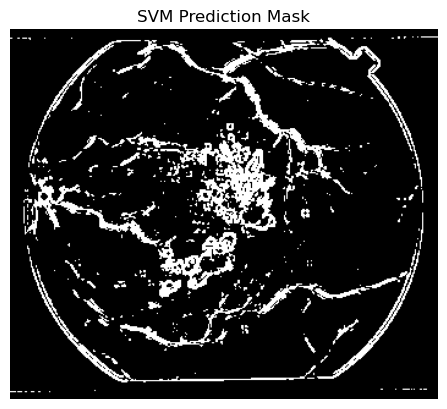

In [10]:
# Create SVM model
svm_model = svm.SVC(kernel='linear', C=1, class_weight='balanced')
# Train the model
svm_model.fit(X_train, y_train)

y_final = svm_model.predict(X_test_scaled)

height, width = gray.shape
grid_h = (height - window_size) // step + 1
grid_w = (width - window_size) // step + 1
prediction_image = np.array(y_final).reshape((grid_h, grid_w))
full_mask = cv2.resize(prediction_image.astype(np.uint8), (width, height), interpolation=cv2.INTER_LINEAR)


output_mask = np.zeros_like(gray, dtype=np.uint8)

for idx, (y, x) in enumerate(positions):
    class_label = y_final[idx]
    output_mask[y:y+window_size, x:x+window_size] = class_label

plt.imshow(output_mask, cmap='gray')
plt.title("SVM Prediction Mask")
plt.axis('off')
plt.show()

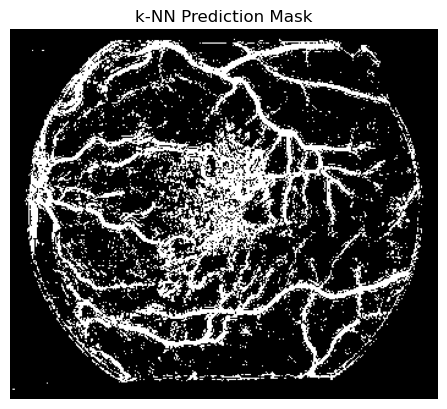

In [11]:
# Create and train k-NN model
knn_model = KNeighborsClassifier(n_neighbors=6)
knn_model.fit(X_train, y_train)

# Make predictions
y_pred_knn = knn_model.predict(X_test)
y_final_knn = knn_model.predict(X_test_scaled)


# Generate mask for k-NN
prediction_image_knn = np.array(y_final_knn).reshape((grid_h, grid_w))
full_mask_knn = cv2.resize(prediction_image_knn.astype(np.uint8), (width, height), interpolation=cv2.INTER_NEAREST)

# Tworzenie maski wynikowej dla k-NN
output_mask_knn = np.zeros_like(gray, dtype=np.uint8)

for idx, (y, x) in enumerate(positions):
    class_label = y_final_knn[idx]
    output_mask_knn[y:y+window_size, x:x+window_size] = class_label

# Wizualizacja
plt.imshow(output_mask_knn, cmap='gray')
plt.title("k-NN Prediction Mask")
plt.axis('off')
plt.show()

In [2]:

images = []
masks = []

for i in range(1, 21):
    images.append(cv2.imread(f"images/im000{i}.ppm"))
    masks.append(cv2.imread(f"images/im000{i}.ah.ppm", cv2.IMREAD_GRAYSCALE))

# Parametry patchy
window_size = 15
step = 2
patches = []
labels = []
positions = []

for idx in range(len(images)):
    image = images[idx]
    mask = masks[idx]

    # Rozmycie i CLAHE
    img_blur = cv2.GaussianBlur(image, (5, 5), 0)
    b, g, r = cv2.split(image)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    b_clahe = clahe.apply(b)
    g_clahe = clahe.apply(g)
    r_clahe = clahe.apply(r)
    img_eq = cv2.merge((b_clahe, g_clahe, r_clahe))

    # Na szaro
    img_rgb = cv2.cvtColor(img_eq, cv2.COLOR_BGR2RGB)
    gray = rgb2gray(img_eq)
    gray = (gray * 255).astype('uint8')  # konwersja do 0–255, jak maska

    h, w = gray.shape

    for y in range(0, h - window_size + 1, step):
        for x in range(0, w - window_size + 1, step):
            center_y = y + window_size // 2
            center_x = x + window_size // 2

            # Sprawdź, czy środek patcha mieści się w obrazie i masce
            if center_y >= h or center_x >= w:
                continue

            patch = gray[y:y+window_size, x:x+window_size].astype('float32') / 255.0
            patch = patch[..., np.newaxis]

            label = mask[center_y, center_x]
            label = 1 if label > 0 else 0

            patches.append(patch)
            labels.append(label)
            positions.append((y, x))  # <-- ZAMIENIAMY na oryginalną pozycję patcha, NIE center


X = np.array(patches)   # (N, 10, 10, 1)
y = np.array(labels)    # (N,)
assert len(positions) == len(X) == len(y)

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(15, 15, 1)),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding="same"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding="same"),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

model.summary()
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=2048)


2025-06-11 01:13:31.281441: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 15, 15, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       200,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 219,649 (858.00 KB)

 Trainable params: 219,649 (858.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
794/794 ━━━━━━━━━━━━━━━━━━━━ 38s 47ms/step - accuracy: 0.9225 - loss: 0.2231 - precision: 0.5178 - recall: 0.1737 - val_accuracy: 0.9534 - val_loss: 0.1241 - val_precision: 0.7426 - val_recall: 0.6229
Epoch 2/10
794/794 ━━━━━━━━━━━━━━━━━━━━ 37s 46ms/step - accuracy: 0.9543 - loss: 0.1206 - precision: 0.7780 - recall: 0.5932 - val_accuracy: 0.9582 - val_loss: 0.1075 - val_precision: 0.7630 - val_recall: 0.6794
Epoch 3/10
794/794 ━━━━━━━━━━━━━━━━━━━━ 37s 46ms/step - accuracy: 0.9587 - loss: 0.1071 - precision: 0.7980 - recall: 0.6409 - val_accuracy: 0.9609 - val_loss: 0.1016 - val_precision: 0.7801 - val_recall: 0.6998
Epoch 4/10
794/794 ━━━━━━━━━━━━━━━━━━━━ 36s 46ms/step - accuracy: 0.9603 - loss: 0.1030 - precision: 0.8073 - recall: 0.6585 - val_accuracy: 0.9619 - val_loss: 0.1011 - val_precision: 0.8494 - val_recall: 0.6268
Epoch 5/10
794/794 ━━━━━━━━━━━━━━━━━━━━ 36s 46ms/step - accuracy: 0.9621 - loss: 0.0980 - precision: 0.8166 - recall: 0.6735 - val_accuracy: 0.9590 - va

In [76]:
window_size = 15
step = 1
image = images[1]
mask = masks[1]

# Rozmycie i CLAHE
img_blur = cv2.GaussianBlur(image, (5, 5), 0)
b, g, r = cv2.split(img_blur)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
b_clahe = clahe.apply(b)
g_clahe = clahe.apply(g)
r_clahe = clahe.apply(r)
img_eq = cv2.merge((b_clahe, g_clahe, r_clahe))

# Konwersja do skali szarości
img_rgb = cv2.cvtColor(img_eq, cv2.COLOR_BGR2RGB)
gray = rgb2gray(img_rgb)
gray = (gray * 255).astype('uint8')

# Przygotowanie patchy
h, w = gray.shape
patches_test = []
positions_test = []

for y in range(0, h - window_size + 1, step):
    for x in range(0, w - window_size + 1, step):
        center_y = y + window_size // 2
        center_x = x + window_size // 2

        if center_y >= h or center_x >= w:
            continue

        patch = gray[y:y+window_size, x:x+window_size].astype('float32') / 255.0
        patch = patch[..., np.newaxis]

        patches_test.append(patch)
        positions_test.append((y, x))

# Konwersja do tablicy
X_test_single = np.array(patches_test)
assert len(X_test_single) == len(positions_test)


13072/13072 ━━━━━━━━━━━━━━━━━━━━ 7s 501us/step


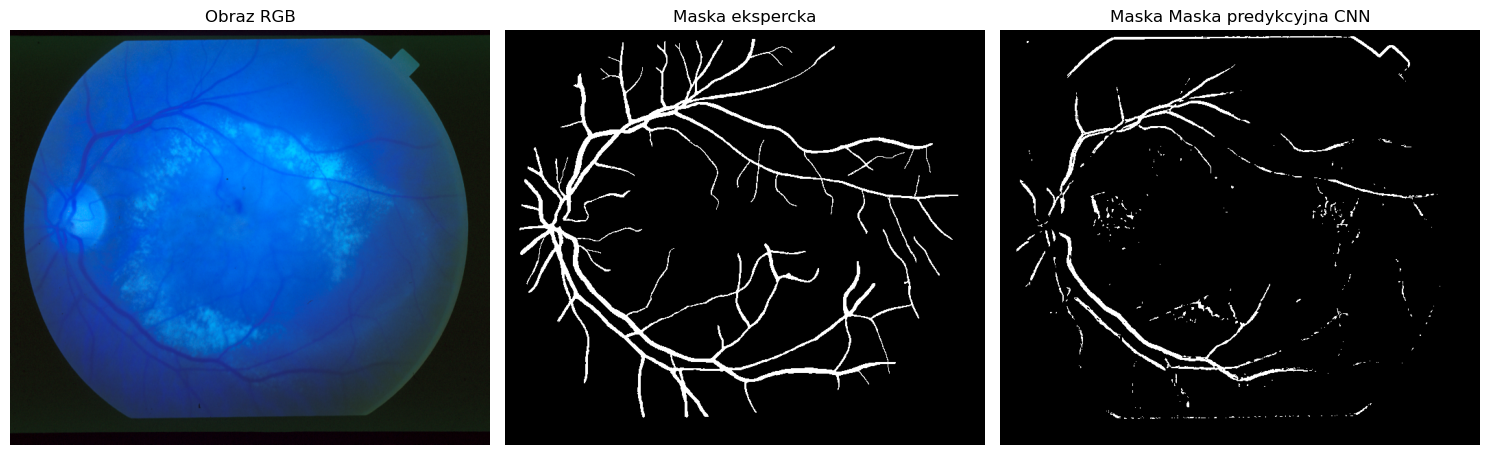

In [77]:
from sklearn.metrics import classification_report, confusion_matrix
# Przewidywanie klas (1 = naczynie, 0 = tło)
y_pred_test = (model.predict(X_test_single) > 0.5).astype(np.uint8).flatten()

# Rekonstrukcja maski
output_mask_pred = np.zeros_like(gray, dtype=np.uint8)

for idx, (y, x) in enumerate(positions_test):
    label = y_pred_test[idx]
    output_mask_pred[y:y+window_size, x:x+window_size] = label


    


fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(images[1])
axes[0].set_title("Obraz RGB")
axes[0].axis('off')

# Maska ekspercka
axes[1].imshow(masks[1], cmap='gray')
axes[1].set_title("Maska ekspercka")
axes[1].axis('off')

axes[2].imshow(output_mask_pred, cmap='gray')
axes[2].set_title("Maska Maska predykcyjna CNN")
axes[2].axis('off')

plt.tight_layout()
plt.show()
